In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
!ls "drive/MyDrive/Datasets/Pong"

Pong-v0_dataset.pickle


In [5]:
import pickle
with open('drive/MyDrive/Datasets/Pong/Pong-v0_dataset.pickle', 'rb') as handle:
    data = pickle.load(handle)

[[array([[[  0,   0,   0],
          [  0,   0,   0],
          [  0,   0,   0],
          ...,
          [109, 118,  43],
          [109, 118,  43],
          [109, 118,  43]],
  
         [[109, 118,  43],
          [109, 118,  43],
          [109, 118,  43],
          ...,
          [109, 118,  43],
          [109, 118,  43],
          [109, 118,  43]],
  
         [[109, 118,  43],
          [109, 118,  43],
          [109, 118,  43],
          ...,
          [109, 118,  43],
          [109, 118,  43],
          [109, 118,  43]],
  
         ...,
  
         [[ 53,  95,  24],
          [ 53,  95,  24],
          [ 53,  95,  24],
          ...,
          [ 53,  95,  24],
          [ 53,  95,  24],
          [ 53,  95,  24]],
  
         [[ 53,  95,  24],
          [ 53,  95,  24],
          [ 53,  95,  24],
          ...,
          [ 53,  95,  24],
          [ 53,  95,  24],
          [ 53,  95,  24]],
  
         [[ 53,  95,  24],
          [ 53,  95,  24],
          [ 53,  95,  24

In [12]:
import numpy as np
data = np.array(data)
actions = set(data[:,1])
actions

{0, 2, 3}

In [13]:
import gym
env = gym.make("Pong-v0")

In [15]:
env.unwrapped.get_action_meanings()

['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']

# Datensatz generieren per Zufallssspiel

erstes Test Notebook

In [ ]:
from gym import spaces
import cv2

class WarpFrame(gym.ObservationWrapper):
    def __init__(self, env):
        """
        Warp frames to 84x84 as done in the Nature paper and later work.
        :param env: (Gym Environment) the environment
        """
        gym.ObservationWrapper.__init__(self, env)
        self.width = 84
        self.height = 84
        self.observation_space = spaces.Box(low=0, high=255, shape=(self.height, self.width, 1),
                                            dtype=env.observation_space.dtype)
        
    def observation(self, frame):
        """
        returns the current observation from a frame
        :param frame: ([int] or [float]) environment frame
        :return: ([int] or [float]) the observation
        """
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        frame = cv2.resize(frame, (self.width, self.height), interpolation=cv2.INTER_AREA)
        return frame[:, :, None]

In [ ]:
def WarpFrameEnv(env_name):
  env = gym.make(env_name)
  env = WarpFrame(env)
  return env

In [ ]:
import gym
import numpy as np
env = WarpFrameEnv("Pong-v0")
x_data = []
y_data = []
saved_episodes = 0
the_end = False
while not the_end:
  done = False
  state = env.reset()
  episode_obs = []
  episode_acts = []
  
  while not done:
    action = env.action_space.sample()
    episode_obs.append(state)
    episode_acts.append(action)
    state, reward, done, info = env.step(action)
    
    if reward < 0:
      episode_acts = []
      episode_obs = []
    elif reward > 0:
      x_data += episode_obs
      y_data += episode_acts
      episode_obs = []
      episode_acts = []
      saved_episodes += 1
      print(saved_episodes)
      if saved_episodes+1 > 5:
        the_end = True

1
2
3
4
5
6


(84, 84, 1)


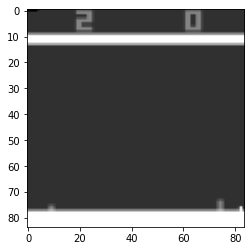

In [ ]:
import matplotlib.pyplot as plt
image = x_data[0]
print(image.shape)
image = image[: , :, 0]
plt.imshow(image, cmap="gray")


In [ ]:
np.shape(x_data), len(y_data)

((451, 84, 84, 1), 451)

In [ ]:
import tensorflow
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam

# DQN und Tagret Net Parameters
INPUT_SHAPE = (84, 84, 1) # (Höhe, Breite, Frames)
OUTPUT_SHAPE = 1
LOSS_FUNCTION = Huber()
#OPTIMIZER = Adam(lr)

# Funktion zum erstellen eines neuronalen Netzes
def build_neural_net(INPUT_SHAPE, OUTPUT_SHAPE, LOSS_FUNCTION, OPTIMIZER):
  net_input = Input(shape=INPUT_SHAPE)
  x = Conv2D(filters=32, kernel_size=(8, 8), strides=(4, 4), padding="same")(net_input)
  x = Activation("relu")(x)
  x = Conv2D(filters=64, kernel_size=(4, 4), strides=(2, 2), padding="same")(x)
  x = Activation("relu")(x)
  x = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding="same")(x)
  x = Activation("relu")(x)
  x = Flatten()(x)
  x = Dense(256)(x)
  x = Activation("relu")(x)
  net_output = Dense(OUTPUT_SHAPE)(x)

  model = Model(inputs=net_input, outputs=net_output)
  model.compile(loss=LOSS_FUNCTION, optimizer=OPTIMIZER)

  return model

# Deep Q-Network
DQN = build_neural_net(INPUT_SHAPE, OUTPUT_SHAPE, LOSS_FUNCTION, OPTIMIZER)

In [ ]:
x_data = np.array(x_data, dtype=np.float32)
y_data = np.array(y_data, dtype=np.float32)
DQN.fit(x=x_data, y=y_data, verbose=1, epochs=100)